# RNN для временных рядов
Для этого примера мы используем данные из экономической базы данных Федерального резерва (FRED) о продажах пива, вина и крепких алкогольных напитков в миллионах долларов с января 1992 года по январь 2019 года (325 записей).

Источник данных: https://fred.stlouisfed.org/series/S4248SM144NCEN

## Импорт

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Для построения графиков, привязанных к дате и времени с помощью matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Загружаем данные
Мы воспользуемся преимуществами встроенного в pandas <a href='https://pandas.pydata.org/pandas-docs/stable/timeseries.html'> DatetimeIndex </a>, передав <tt> parse_dates = True </tt>

In [11]:
df = pd.read_csv('Alcohol_Sales.csv',index_col=0,parse_dates=True)
df

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2022-04-01,15584
2022-05-01,16600
2022-06-01,17700


## Выводим график
Мы можем добавить заголовки, метки осей и другие функции на график. <br>
Мы собираемся сжать ось X, чтобы соответствовать ширине фактических данных, с помощью <tt> plt.autoscale (axis = 'x', sharp = True) </tt>. <br>
В качестве альтернативы вы можете установить свои собственные ограничения с помощью <tt> plt.xlim (pd.Timestamp ('1992-01-01'), pd.Timestamp ('2019-01-01')) </tt> или другие значения.

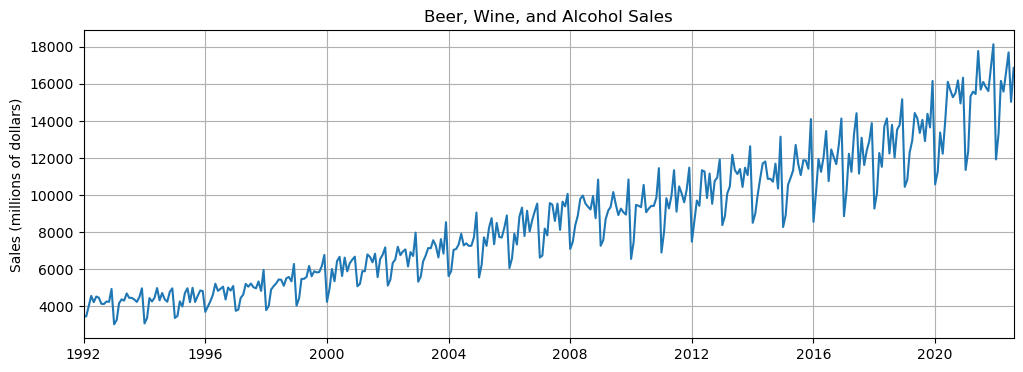

In [9]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Подготовка данных
На следующих шагах мы разделим данные на обучающие / тестовые наборы, затем нормализуем тренировочные значения так, чтобы они падали в интервал между -1 и 1 (для улучшения обучения). Мы будем обучать модель, а затем прогнозировать период, соответствующий тестовому набору (1 год, 12 точек). Наконец, мы попробуем прогнозировать в "туманное" будущее.

In [16]:
# Извлечь значения из исходного файла .csv
y = df['S4248SM144NCEN'].values.astype(float)

# определить размер тестового набора
test_size = 12

# Создааем обучающий и тестовый наборы
train_set = y[:-test_size]
test_set = y[-test_size:]

In [15]:
test_set

array([15824., 15613., 16896., 18139., 11926., 13333., 16165., 15584.,
       16600., 17700., 15031., 16860.])

## Нормализуем данные
Формула для нормализации данных:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
где $ \mu $ - среднее значение, а $ \sigma $ - стандартное отклонение. <br>

### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
где $a={-1}$ и $b=1$<br>

Мы можем использовать Scikit-Learn, чтобы сделать это, с <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

ПРИМЕЧАНИЕ. Мы хотим  нормализовать только тренировочный набор, чтобы избежать утечки данных. Если мы включим тестовый набор, то более высокие средние значения тестового набора могут стать частью сигнала в обучающем наборе.

После использования преобразованных данных для обучения модели и создания прогнозов мы будем применять inverse_transform для прогнозируемых значений, чтобы мы могли сравнить их с фактическими данными из теста.

In [17]:
from sklearn.preprocessing import MinMaxScaler

# 
scaler = MinMaxScaler(feature_range=(-1, 1))

In [24]:
# нормализуем обучающее множество
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
print(f"Min: {train_norm.min()}")
print(f"Max: {train_norm.max()}")
print(f"Mean: {train_norm.mean()}")
print(f"Type: {type(train_norm)}")

Min: -1.0
Max: 1.0000000000000002
Mean: -0.27210633198837164
Type: <class 'numpy.ndarray'>


## Подготовка данных для LSTM
Здесь мы создадим наш список (seq / label) кортежей из обучающего набора. Напомним, что LSTM использует окно для выборки, поэтому размер нашего обучающего набора станет ((325 - test_size) - window_size).

In [25]:
# Конвертируем train_norm из массива в тензор
train_norm = torch.FloatTensor(train_norm).view(-1)

# размер окна
window_size = 12

# Функция для создания обучающих примеров seq/label 
def input_data(seq, ws):  # ws -- размер окна
    out = []
    L = len(seq)
    for i in range(L - ws):
        window = seq[i:i + ws]
        label = seq[i+ws:i + ws + 1]
        out.append((window, label))
    return out

# Применяем функцию для input_data  и получаем нормализованный набор для обучения: train_norm
train_data = input_data(train_norm, window_size)
len(train_data)  # 

344

In [26]:
# Отобразим первый seq/label элемент из train_data
train_data[4]

(tensor([-0.8386, -0.7968, -0.8054, -0.8500, -0.8515, -0.8334, -0.8360, -0.7416,
         -1.0000, -0.9688, -0.8469, -0.8174]),
 tensor([-0.8269]))

## Определяем модель
мы будем использовать LSTM слой размера (1,100).

In [27]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Добавляем LSTM слой:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Добавляем полносвязный слой:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Инициализируем h0 и c0:
        self.hidden = (torch.zeros(1, 1, self.hidden_size),
                       torch.zeros(1, 1, self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1,- 1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # нам нужно только последнее значение

## Создаем модель, определяем функцию потерь и оптимизатор

In [28]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

## Обучаем модель

In [29]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # извлекаем последовательность и метки из обучающего множества
    for seq, y_train in train_data:
        
        # сбрасываем параметры и скрытые состояния 
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # выводим результат обучения
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00102762
Epoch:  2 Loss: 0.00370055
Epoch:  3 Loss: 0.01956308
Epoch:  4 Loss: 0.02458088
Epoch:  5 Loss: 0.00583525
Epoch:  6 Loss: 0.01664557
Epoch:  7 Loss: 0.00385951
Epoch:  8 Loss: 0.00824014
Epoch:  9 Loss: 0.01450130
Epoch: 10 Loss: 0.00594980
Epoch: 11 Loss: 0.00843653
Epoch: 12 Loss: 0.01513163
Epoch: 13 Loss: 0.02144122
Epoch: 14 Loss: 0.00004879
Epoch: 15 Loss: 0.01276013
Epoch: 16 Loss: 0.00403855
Epoch: 17 Loss: 0.01303975
Epoch: 18 Loss: 0.00820005
Epoch: 19 Loss: 0.01589093
Epoch: 20 Loss: 0.00946345
Epoch: 21 Loss: 0.00672806
Epoch: 22 Loss: 0.00769648
Epoch: 23 Loss: 0.01217090
Epoch: 24 Loss: 0.01219178
Epoch: 25 Loss: 0.01254079
Epoch: 26 Loss: 0.00806144
Epoch: 27 Loss: 0.01888069
Epoch: 28 Loss: 0.00167133
Epoch: 29 Loss: 0.00712858
Epoch: 30 Loss: 0.01859564
Epoch: 31 Loss: 0.03768701
Epoch: 32 Loss: 0.00003350
Epoch: 33 Loss: 0.00429269
Epoch: 34 Loss: 0.00807480
Epoch: 35 Loss: 0.02250675
Epoch: 36 Loss: 0.00119117
Epoch: 37 Loss: 0.02029816
E

## Предсказываем значения (и сравниваем с известным тестовым набором)

In [30]:
future = 12

# Добавляем последнее окно значений обучения в список прогнозов.
preds = train_norm[-window_size:].tolist()

# Установим модель в режим оценки
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [31]:
# Выводим значения предсказаний
preds[window_size:]    # то же самое что preds[-future:]

[0.7992842793464661,
 0.8013343214988708,
 0.7467207312583923,
 0.9506237506866455,
 0.34092646837234497,
 0.7672461867332458,
 0.8462758660316467,
 0.7602430582046509,
 0.8909088969230652,
 0.778168261051178,
 0.7571192383766174,
 0.8059874773025513]

## Обращаем нормализацию
Мы хотим сравнить наши тестовые прогнозы с исходными данными, поэтому нам нужно обратить предыдущий шаг нормализации. Обратите внимание, что <tt> inverse_transform </tt> использует последние примененные параметры; мы можем изменить масштаб на основе тестовых данных, но не на основе предыдущих обучающих данных.

In [32]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[16296.22334948],
       [16311.33728525],
       [15908.6985912 ],
       [17411.97360194],
       [12916.98038808],
       [16060.02251169],
       [16642.66882232],
       [16008.39194661],
       [16971.72584257],
       [16140.5455046 ],
       [15985.36158493],
       [16345.64267641]])

In [33]:
df['S4248SM144NCEN'][-12:]

DATE
2021-09-01    15824
2021-10-01    15613
2021-11-01    16896
2021-12-01    18139
2022-01-01    11926
2022-02-01    13333
2022-03-01    16165
2022-04-01    15584
2022-05-01    16600
2022-06-01    17700
2022-07-01    15031
2022-08-01    16860
Name: S4248SM144NCEN, dtype: int64

Похоже, наши прогнозы оказались не так уж плохи!
## Выводим графики


In [39]:
# 
x = np.arange('2021-09-01', '2022-09-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
       '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
       '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01'],
      dtype='datetime64[D]')

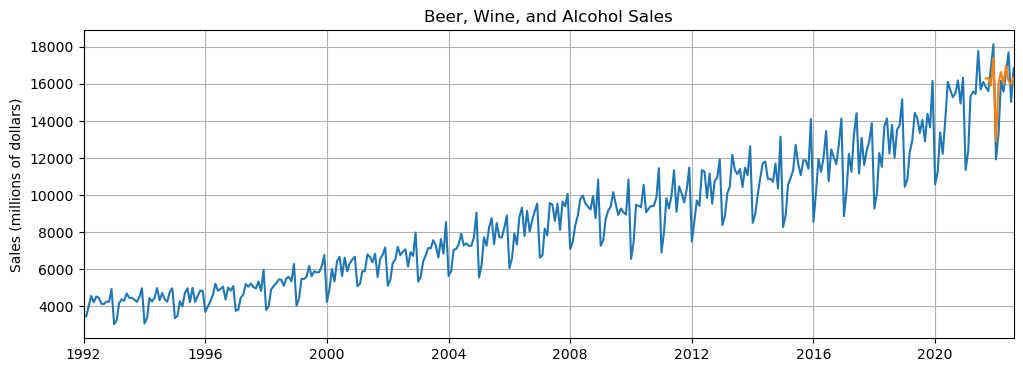

In [40]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

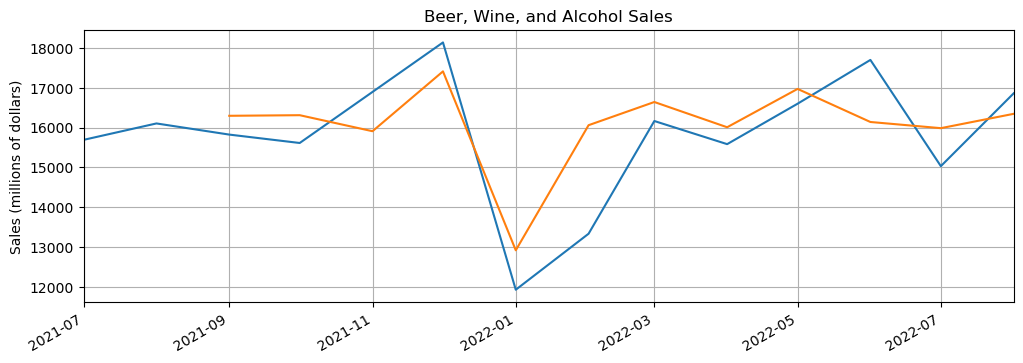

In [44]:
# рисуем хвост графика
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# 
plt.plot(df['S4248SM144NCEN']['2021-07-01':])
plt.plot(x,true_predictions)
plt.show()

Для получения дополнительной информации о форматировании даты по оси X в matplotlib, ознакомьтесь с <a href='https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.autofmt_xdate'><tt><strong>matplotlib.figure.Figure.autofmt_xdate</strong></tt></a> и <a href='https://matplotlib.org/api/dates_api.html#matplotlib.dates.DateFormatter'><tt><strong>matplotlib.dates.DateFormatter</strong></tt></a>

# Прогнозирование "туманного" будущего
На этот раз мы продолжим обучение модели, используя весь набор данных, и прогнозируем на 12 шагов в будущее.

In [45]:
epochs = 100

# вернем модель в режим обучения
model.train()

# масштабируем весь датасет
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # тренируем на всем датасете
    for seq, y_train in all_data:  
        
        # сброс параметров
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # выводим результат
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00580146
Epoch:  2 Loss: 0.02365818
Epoch:  3 Loss: 0.00403619
Epoch:  4 Loss: 0.00407624
Epoch:  5 Loss: 0.00568645
Epoch:  6 Loss: 0.00611006
Epoch:  7 Loss: 0.00529628
Epoch:  8 Loss: 0.00118647
Epoch:  9 Loss: 0.00430179
Epoch: 10 Loss: 0.00553917
Epoch: 11 Loss: 0.00423309
Epoch: 12 Loss: 0.00675963
Epoch: 13 Loss: 0.03150139
Epoch: 14 Loss: 0.00309762
Epoch: 15 Loss: 0.01190117
Epoch: 16 Loss: 0.00337587
Epoch: 17 Loss: 0.00547461
Epoch: 18 Loss: 0.00299712
Epoch: 19 Loss: 0.00396710
Epoch: 20 Loss: 0.00552659
Epoch: 21 Loss: 0.00683677
Epoch: 22 Loss: 0.00241193
Epoch: 23 Loss: 0.00385950
Epoch: 24 Loss: 0.00230998
Epoch: 25 Loss: 0.02776058
Epoch: 26 Loss: 0.00297023
Epoch: 27 Loss: 0.00225288
Epoch: 28 Loss: 0.00040254
Epoch: 29 Loss: 0.00762259
Epoch: 30 Loss: 0.00002685
Epoch: 31 Loss: 0.00000001
Epoch: 32 Loss: 0.00144082
Epoch: 33 Loss: 0.00694017
Epoch: 34 Loss: 0.00573817
Epoch: 35 Loss: 0.00278741
Epoch: 36 Loss: 0.00031567
Epoch: 37 Loss: 0.00251167
E

## Предсказываем и выводим на печать

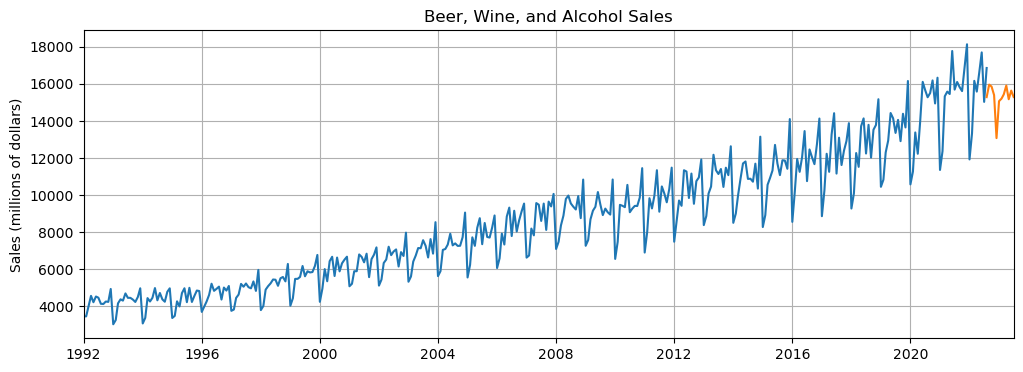

In [55]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # сбрасываем параметры
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# обращение нормализации
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# Вывод графиков
x = np.arange('2022-08-01', '2023-08-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

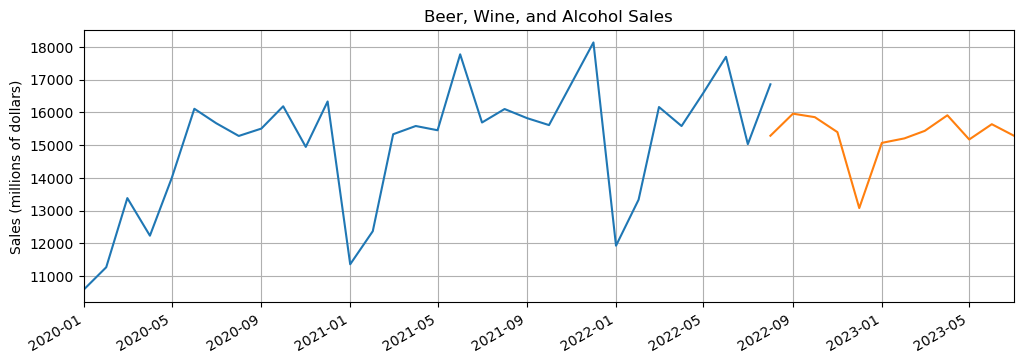

In [57]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2020-01-01':])
plt.plot(x, true_predictions[window_size:])
plt.show()

## Готово!